# Machine Learning with PyTorch and Scikit-Learn  
# -- Code Examples

In [170]:
import sys
sys.path.insert(0, '..')

In [171]:
from sklearn.datasets import fetch_openml


X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X.values
y = y.astype(int).values

print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


Normalize to [-1, 1] range:

In [172]:
X = ((X / 255.) - .5) * 2

Visualize the first digit of each class:

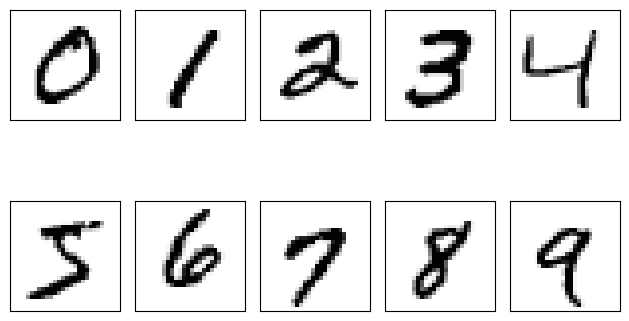

In [173]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    img = X[y == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

Split into training, validation, and test set:

In [174]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=123, stratify=y)

# X_train, X_valid, y_train, y_valid = train_test_split(
#     X_temp, y_temp, test_size=1, random_state=123, stratify=y_temp)


# optional to free up some memory by deleting non-used arrays:
# del X_temp, y_temp, X, y

## Implementing a multi-layer perceptron

In [175]:
import numpy as np

In [176]:
##########################
### MODEL
##########################

def sigmoid(z):                                        
    return 1. / (1. + np.exp(-z))


def int_to_onehot(y, num_labels):

    ary = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        ary[i, val] = 1
    return ary


class NeuralNetMLP:

    def __init__(self, num_features, num_hidden_f, num_hidden_s, num_classes, random_seed=123):
        super().__init__()
        
        self.num_classes = num_classes
        
        # hidden
        rng = np.random.RandomState(random_seed)
        
        # first hidden layer
        self.weight_h = rng.normal(loc=0.0, scale=0.1, size=(num_hidden_f, num_features))
        self.bias_h = np.zeros(num_hidden_f)

        # second hidden layer
        self.weight_s = rng.normal(loc=0.0, scale=0.1, size=(num_hidden_s, num_hidden_f))
        self.bias_s = np.zeros(num_hidden_s)
        
        # output
        self.weight_out = rng.normal(loc=0.0, scale=0.1, size=(num_classes, num_hidden_s))
        self.bias_out = np.zeros(num_classes)
        
    def forward(self, x):
        # Hidden layer
        # input dim: [n_examples, n_features] dot [n_hidden, n_features].T
        # output dim: [n_examples, n_hidden]
        z_h = np.dot(x, self.weight_h.T) + self.bias_h
        a_h = sigmoid(z_h)

        # Second hidden layer
        # input dim: [n_examples, n_hidden] dot [n_hidden, n_hidden].T
        # output dim: [n_examples, n_hidden]
        z_s = np.dot(a_h, self.weight_s.T) + self.bias_s
        a_s = sigmoid(z_s)


        # Output layer
        # input dim: [n_examples, n_hidden] dot [n_classes, n_hidden].T
        # output dim: [n_examples, n_classes]
        z_out = np.dot(a_s, self.weight_out.T) + self.bias_out
        a_out = sigmoid(z_out)
        return a_h, a_s, a_out

    def backward(self, x, a_h,a_s, a_out, y):  
    
        #########################
        ### Output layer weights
        #########################
        
        # onehot encoding
        y_onehot = int_to_onehot(y, self.num_classes)

        # Part 1: dLoss/dOutWeights
        ## = dLoss/dOutAct * dOutAct/dOutNet * dOutNet/dOutWeight
        ## where DeltaOut = dLoss/dOutAct * dOutAct/dOutNet
        ## for convenient re-use
        
        # input/output dim: [n_examples, n_classes]
        d_loss__d_a_out = 2.*(a_out - y_onehot) / y.shape[0]

        # input/output dim: [n_examples, n_classes]
        d_a_out__d_z_out = a_out * (1. - a_out) # sigmoid derivative

        # output dim: [n_examples, n_classes]
        delta_out = d_loss__d_a_out * d_a_out__d_z_out # "delta (rule) placeholder"

        # gradient for output weights
        # input dim: [n_classes, n_examples] dot [n_examples, n_hidden]
        # output dim: [n_classes, n_hidden]
        d_loss__dw_out = np.dot(delta_out.T, a_s)
        d_loss__db_out = np.sum(delta_out, axis=0)
        

        #################################        
        # Part 2: dLoss/dHiddenWeights
        ## = DeltaOut * dOutNet/dHiddenAct * dHiddenAct/dHiddenNet * dHiddenNet/dWeight
        # gradient for second hidden weights
        
        d_z_out__a_s = self.weight_out
        d_loss__a_s = np.dot(delta_out, d_z_out__a_s)
        d_a_s__d_z_s = a_s * (1. - a_s)
        delta_s = d_loss__a_s * d_a_s__d_z_s
        d_loss_dw_s = np.dot(delta_s.T, a_h)
        d_loss_db_s = np.sum(delta_s, axis=0)



        # [n_classes, n_hidden]
        d_z_out__a_h = self.weight_s
        
        # output dim: [n_examples, n_hidden]
        d_loss__a_h = np.dot(delta_s, d_z_out__a_h) 
        
        # [n_examples, n_hidden]
        d_a_h__d_z_h = a_h * (1. - a_h) # sigmoid derivative
        
        # [n_examples, n_features]
        d_z_h__d_w_h = x
        
        # output dim: [n_hidden, n_features]
        d_loss__d_w_h = np.dot((d_loss__a_h * d_a_h__d_z_h).T, d_z_h__d_w_h)
        d_loss__d_b_h = np.sum((d_loss__a_h * d_a_h__d_z_h), axis=0)

        return (d_loss__dw_out, d_loss__db_out,d_loss_dw_s, d_loss_db_s, 
                d_loss__d_w_h, d_loss__d_b_h)

In [177]:
model = NeuralNetMLP(num_features=28*28,
                     num_hidden_f=50,
                     num_hidden_s=50,
                     num_classes=10)

## Coding the neural network training loop

Defining data loaders:

In [178]:
import numpy as np

num_epochs = 50
minibatch_size = 100


def minibatch_generator(X, y, minibatch_size):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    for start_idx in range(0, indices.shape[0] - minibatch_size 
                           + 1, minibatch_size):
        batch_idx = indices[start_idx:start_idx + minibatch_size]
        
        yield X[batch_idx], y[batch_idx]

        
# iterate over training epochs
for i in range(num_epochs):

    # iterate over minibatches
    minibatch_gen = minibatch_generator(
        X_train, y_train, minibatch_size)
    
    for X_train_mini, y_train_mini in minibatch_gen:

        break
        
    break
    
print(X_train_mini.shape)
print(y_train_mini.shape)

(100, 784)
(100,)


Defining a function to compute the loss and accuracy

In [179]:
def mse_loss(targets, probas, num_labels=10):
    onehot_targets = int_to_onehot(targets, num_labels=num_labels)
    return np.mean((onehot_targets - probas)**2)


def accuracy(targets, predicted_labels):
    return np.mean(predicted_labels == targets) 


# _, _, probas = model.forward(X_valid)
# mse = mse_loss(y_valid, probas)

# predicted_labels = np.argmax(probas, axis=1)
# acc = accuracy(y_valid, predicted_labels)

# print(f'Initial validation MSE: {mse:.1f}')
# print(f'Initial validation accuracy: {acc*100:.1f}%')

In [180]:
def compute_mse_and_acc(nnet, X, y, num_labels=10, minibatch_size=100):
    mse, correct_pred, num_examples = 0., 0, 0
    minibatch_gen = minibatch_generator(X, y, minibatch_size)
        
    for i, (features, targets) in enumerate(minibatch_gen):

        _, _, probas = nnet.forward(features)
        predicted_labels = np.argmax(probas, axis=1)
        
        onehot_targets = int_to_onehot(targets, num_labels=num_labels)
        loss = np.mean((onehot_targets - probas)**2)
        correct_pred += (predicted_labels == targets).sum()
        
        num_examples += targets.shape[0]
        mse += loss

    mse = mse/(i+1)
    acc = correct_pred/num_examples
    return mse, acc

In [181]:
# mse, acc = compute_mse_and_acc(model, X_valid, y_valid)
# print(f'Initial valid MSE: {mse:.1f}')
# print(f'Initial valid accuracy: {acc*100:.1f}%')

In [182]:
def train(model, X_train, y_train, X_valid, y_valid, num_epochs,
          learning_rate=0.1):
    
    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []
    
    for e in range(num_epochs):

        # iterate over minibatches
        minibatch_gen = minibatch_generator(
            X_train, y_train, minibatch_size)

        for X_train_mini, y_train_mini in minibatch_gen:
            
            #### Compute outputs ####
            a_h, a_s, a_out = model.forward(X_train_mini)

            #### Compute gradients ####
            (d_loss__d_w_out, d_loss__d_b_out,d_loss_dw_s, d_loss_db_s, 
            d_loss__d_w_h, d_loss__d_b_h) = \
                model.backward(X_train_mini, a_h, a_s, a_out, y_train_mini)

            #### Update weights ####
            model.weight_h -= learning_rate * d_loss__d_w_h
            model.bias_h -= learning_rate * d_loss__d_b_h
            model.weight_s -= learning_rate * d_loss_dw_s
            model.bias_s -= learning_rate * d_loss_db_s
            model.weight_out -= learning_rate * d_loss__d_w_out
            model.bias_out -= learning_rate * d_loss__d_b_out
        
        #### Epoch Logging ####        
        train_mse, train_acc = compute_mse_and_acc(model, X_train, y_train)
        # valid_mse, valid_acc = compute_mse_and_acc(model, X_valid, y_valid)
        # train_acc, valid_acc = train_acc*100, valid_acc*100
        train_acc = train_acc*100
        epoch_train_acc.append(train_acc)
        # epoch_valid_acc.append(valid_acc)
        epoch_loss.append(train_mse)
        print(f'Epoch: {e+1:03d}/{num_epochs:03d} '
              f'| Train MSE: {train_mse:.2f} '
              f'| Train Acc: {train_acc:.2f}% ')
            #   f'| Valid Acc: {valid_acc:.2f}%')

    return epoch_loss, epoch_train_acc, epoch_valid_acc

In [183]:
np.random.seed(123) # for the training set shuffling

epoch_loss, epoch_train_acc, epoch_valid_acc = train(
    model, X_train, y_train, None, None,
    num_epochs=50, learning_rate=0.1)

np.save('epoch_loss_modified.npy', epoch_loss)
np.save('epoch_train_acc_modified.npy', epoch_train_acc)    
# X_valid, y_valid -> replaced with None

Epoch: 001/050 | Train MSE: 0.09 | Train Acc: 23.36% 
Epoch: 002/050 | Train MSE: 0.08 | Train Acc: 26.32% 
Epoch: 003/050 | Train MSE: 0.07 | Train Acc: 50.09% 
Epoch: 004/050 | Train MSE: 0.06 | Train Acc: 65.68% 
Epoch: 005/050 | Train MSE: 0.04 | Train Acc: 76.82% 
Epoch: 006/050 | Train MSE: 0.03 | Train Acc: 83.58% 
Epoch: 007/050 | Train MSE: 0.03 | Train Acc: 86.82% 
Epoch: 008/050 | Train MSE: 0.02 | Train Acc: 88.20% 
Epoch: 009/050 | Train MSE: 0.02 | Train Acc: 89.15% 
Epoch: 010/050 | Train MSE: 0.02 | Train Acc: 89.75% 
Epoch: 011/050 | Train MSE: 0.02 | Train Acc: 90.30% 
Epoch: 012/050 | Train MSE: 0.02 | Train Acc: 90.60% 
Epoch: 013/050 | Train MSE: 0.02 | Train Acc: 91.04% 
Epoch: 014/050 | Train MSE: 0.02 | Train Acc: 91.34% 
Epoch: 015/050 | Train MSE: 0.01 | Train Acc: 91.61% 
Epoch: 016/050 | Train MSE: 0.01 | Train Acc: 91.93% 
Epoch: 017/050 | Train MSE: 0.01 | Train Acc: 92.09% 
Epoch: 018/050 | Train MSE: 0.01 | Train Acc: 92.38% 
Epoch: 019/050 | Train MSE: 

## Evaluating the neural network performance

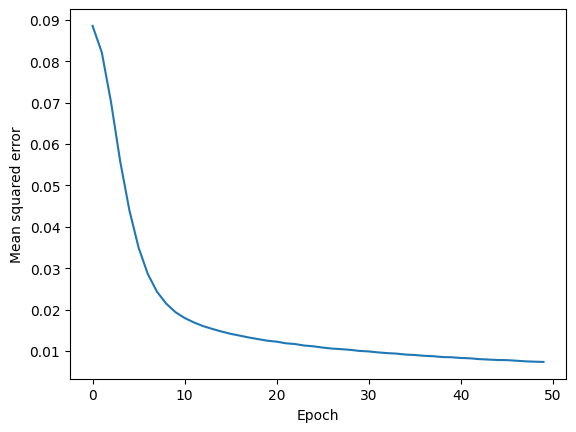

In [184]:
plt.plot(range(len(epoch_loss)), epoch_loss)
plt.ylabel('Mean squared error')
plt.xlabel('Epoch')
plt.show()

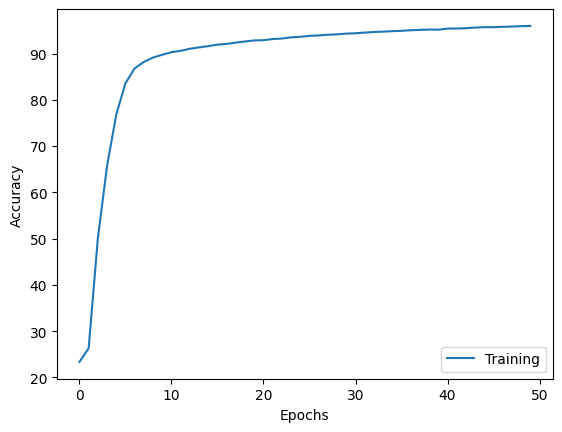

In [185]:
plt.plot(range(len(epoch_train_acc)), epoch_train_acc,
         label='Training')
# plt.plot(range(len(epoch_valid_acc)), epoch_valid_acc,
#          label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.show()

In [186]:
from sklearn.metrics import roc_auc_score

test_mse, test_acc = compute_mse_and_acc(model, X_test, y_test)
print(f'Test accuracy: {test_acc*100:.2f}%')
# Compute the macro AUC
_, _, probas = model.forward(X_test)
# test_pred = np.argmax(probas, axis=1)
y_test_onehot = int_to_onehot(y_test, num_labels=10)
macro_auc = roc_auc_score(y_test_onehot, probas, average='macro', multi_class='ovr')

print(f'Test Macro AUC: {macro_auc:.2f}')
np.save('test_mse_modified.npy', test_mse)
np.save('test_acc_modified.npy', test_acc)

Test accuracy: 94.90%
Test Macro AUC: 0.99


Plot failure cases:

In [187]:
X_test_subset = X_test[:1000, :]
y_test_subset = y_test[:1000]

_, _, probas = model.forward(X_test_subset)
test_pred = np.argmax(probas, axis=1)

misclassified_images = X_test_subset[y_test_subset != test_pred][:25]
misclassified_labels = test_pred[y_test_subset != test_pred][:25]
correct_labels = y_test_subset[y_test_subset != test_pred][:25]

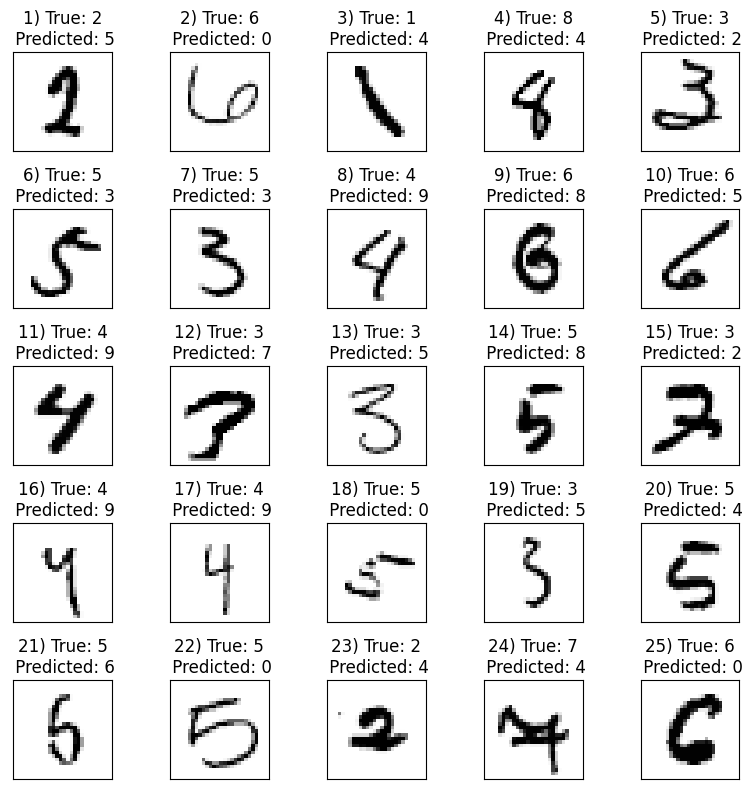

In [188]:
fig, ax = plt.subplots(nrows=5, ncols=5, 
                       sharex=True, sharey=True, figsize=(8, 8))
ax = ax.flatten()
for i in range(25):
    img = misclassified_images[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title(f'{i+1}) '
                    f'True: {correct_labels[i]}\n'
                    f' Predicted: {misclassified_labels[i]}')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
#plt.savefig('figures/11_09.png', dpi=300)
plt.show()

---

Readers may ignore the next cell.

In [189]:
! python ../.convert_notebook_to_script.py --input ch11.ipynb --output ch11.py

python: can't open file 'c:\\Users\\idozi\\.convert_notebook_to_script.py': [Errno 2] No such file or directory
